In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
from collections import Counter
import cv2
import matplotlib.pyplot as plt 
from datetime import datetime
import json

In [2]:
train_df = pd.read_csv('train.csv')
sample = pd.read_csv('sample_submission.csv')

# Get Boxing Info

In [3]:
with open('whale_faces.json', encoding='utf-8') as data_file:
    box_data = json.loads(data_file.read())

In [4]:
box_data[0]['annotations'][0]

{'class': 'Head',
 'height': 661.4783999999997,
 'type': 'rect',
 'width': 825.2927999999999,
 'x': 340.0703999999999,
 'y': 659.4047999999998}

In [5]:
bb_json = {}
for i in range(len(box_data)):
    filename = box_data[i]['filename'].split('/')[-1]
    try:
        bb_json[filename] = box_data[i]['annotations'][0]
    except:
        print(i,filename)

2926 w_7077.jpg


In [6]:
!pwd

/home/ec2-user/whales2


In [7]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [8]:
issue = read_image('/home/ec2-user/whales2/imgs/w_7077.jpg')

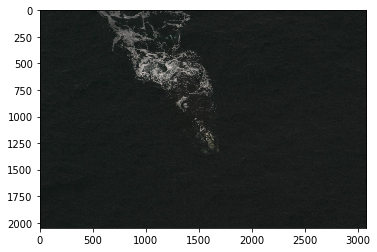

In [9]:
plt.imshow(issue)

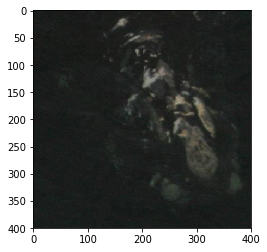

In [10]:
plt.imshow(issue[1000:1400,1300:1700])

In [11]:
bb_json['w_7077.jpg'] = {'class': 'Head',
 'height': 400,
 'type': 'rect',
 'width': 400,
 'x': 1300,
 'y': 1000}

In [12]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

# Get Y

In [13]:
# this will give us what we need to add the encoded y
y_id_to_num = {}
y_num_to_id = {}
uniq_y = sample.columns[1:] #this way they are in order of needed submission
for i in range(len(uniq_y)):
    y_id_to_num[uniq_y[i]] = i
    y_num_to_id[i] = uniq_y[i]

# add an encoded version of the y to dataframe
train_df['y'] = train_df["whaleID"].map(y_id_to_num)
#dictionary of image name to label
name_id_dict = dict( zip( train_df["Image"], train_df["y"]))

In [14]:
def get_Y(path, label2ind):
    """Given an image path get y"""
    im_name = path.parts[-1]
    im_class = label2ind[im_name]
    if im_name in bb_json:
        x = bb_json[im_name]
        return np.array([x['y'], x['x'], x['y'] + x['height'], x['x']+ x['width'], im_class])
    return np.array([0.0, 0.0, 0.0, 0.0, im_class])

In [15]:
def get_bb(files, label2ind):
    return [get_Y(p, label2ind) for p in files]

# Transforms with bounding boxes

In [16]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [17]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)


In [18]:
def make_bb_px(y, s):
    """ Makes an image of size x retangular bounding box"""
    r,c,*_ = s #s is shape of x
    Y = np.zeros((r, c))
    y = y.astype(np.int)
    Y[y[0]:y[2], y[1]:y[3]] = 1.
    return Y

def to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

In [19]:
def resize_images_ratio(im, sz=300, r=1.75):
    sz2 = int(r*sz)
    return cv2.resize(im, (sz2, sz))

In [20]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [21]:
def random_cropXY(x, Y, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    x = crop(x, start_r, start_c, target_r, target_c)
    Y = crop(Y, start_r, start_c, target_r, target_c)
    return x, Y

In [22]:
def get_shape_original_images(org_path):
    files = list(org_path.iterdir())
    shapes = {f.parts[-1]: cv2.imread(str(f)).shape for f in files}
    return shapes

In [23]:
PATH = Path('/home/ec2-user/whales2/')

In [24]:
shapes = get_shape_original_images(PATH/'imgs')

KeyboardInterrupt: 

In [24]:
import pickle

In [25]:
shapes = pickle.load(open('shapes','rb'))

In [26]:
def transformsXY(path, bb, transforms, shape_x, sz):
    sz2 = int(sz*1.778)
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    # make Y with the original size of x
    Y = make_bb_px(bb, shape_x)
    if transforms:
        # already resized to 300
        #x = resize_images_ratio(x, sz+20)
        Y = resize_images_ratio(Y, 300)
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y, sz, sz2)
    else:
        x = resize_images_ratio(x, sz)
        Y = resize_images_ratio(Y, sz)
    return x, to_bb(Y)

In [27]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

In [28]:
# testing
train_path=PATH/"train-300"
files = list(train_path.iterdir())
test = files[:2]

In [29]:
test

[PosixPath('/home/ec2-user/whales2/train-300/w_1458.jpg'),
 PosixPath('/home/ec2-user/whales2/train-300/w_1195.jpg')]

In [30]:
bbs = get_bb(test, name_id_dict)
bbs

[array([ 599.15529179, 1108.43728982, 1291.51251786, 1754.19354875,
         131.        ]),
 array([ 625.78441587, 1181.66738103,  991.93487197, 1604.4047258 ,
         278.        ])]

In [31]:
im = cv2.imread(str(test[1]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
bb = bbs[1][:4]
bb

array([ 625.78441587, 1181.66738103,  991.93487197, 1604.4047258 ])

In [32]:
Y = make_bb_px(bb, shapes["w_1195.jpg"])
Y = resize_images_ratio(Y, 300)
bb0 = to_bb(Y)
bb0

array([114., 252., 179., 341.], dtype=float32)

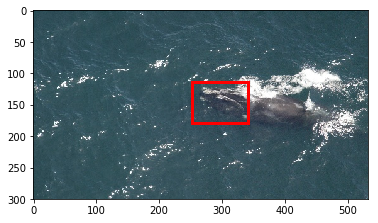

In [33]:
show_corner_bb(im, bb0)

In [34]:
im, bb_t = transformsXY(str(test[1]), bb, True, shapes["w_1195.jpg"], sz=280)

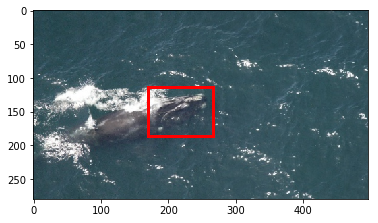

In [35]:
show_corner_bb(im, bb_t)

# New Dataset

In [36]:
def get_files(path=PATH/"train-300"):
    files = list(path.iterdir())
    names = [f.parts[-1] for f in files]
    labels = [name_id_dict[n] for n in names]
    return files, labels

In [37]:
train_files, y_train = get_files()
valid_files, y_valid = get_files(PATH/"valid-300")

In [38]:
class WhaleDataset(Dataset):
    def __init__(self, files, y, shapes, transforms=False, sz=280):
        self.transforms = transforms
        self.sz = sz
        self.files = files
        self.y = get_bb(self.files, name_id_dict)
        self.shapes = shapes
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        shape = self.shapes[path.parts[-1]]
        y = self.y[idx]
        bb = y[:4]
        x, y_bb = transformsXY(path, bb, self.transforms, shape, self.sz)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y[4], y_bb

In [39]:
train_ds = WhaleDataset(train_files, y_train, shapes, transforms=True)
valid_ds = WhaleDataset(valid_files, y_valid, shapes)

In [40]:
x, y_class, y_bb= train_ds[20]
x.shape, y_class, y_bb

((3, 280, 497), 171.0, array([147., 184., 220., 275.], dtype=float32))

In [41]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

# Model

In [42]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet152(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet152
        layers = list(resnet.children())[:9]
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(2048)
        self.bn2 = nn.BatchNorm1d(2048)
        self.fc1 = nn.Linear(2048, 2048)
        self.fc2 = nn.Linear(2048, 447)
        self.fc3 = nn.Linear(2048, 4)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        #x = nn.Dropout(0.1)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        #x = nn.Dropout(0.1)(x)
        x = self.bn2(x)
        x_class = self.fc2(x)
        x_bb = self.fc3(x)
        return x_class, x_bb

In [43]:
net = Net().cuda()

In [44]:
x, y1, y2 = next(iter(train_dl))

In [45]:
y1 = y1.cuda()
y2 = y2.cuda()
out_class, out_bb = net(x.float().cuda())

In [46]:
y1.long()

tensor([ 354,  261,   50,  394,  351,  175,  330,  110,  184,  414,
          67,  381,  442,  109,  211,  323,  217,  199,   59,  440,
          15,   93,  278,  239,   81,  175,  322,   19,  239,  157,
          59,  238,  226,  446,  329,  431,  136,  245,   59,   43,
         191,   99,  160,   60,   21,  275,  241,  271,   12,  114,
         253,   35,  390,   77,  391,   55,  260,  234,  243,   67,
         236,  237,  143,  424], device='cuda:0')

In [47]:
out_class

tensor([[-1.3737e-02,  7.5332e-01,  3.1945e-01,  ..., -1.5959e-01,
          1.8058e-02, -9.4688e-02],
        [ 5.7206e-01, -4.7908e-01,  5.5670e-02,  ...,  5.9470e-01,
         -2.8563e-01,  5.6815e-01],
        [-3.3365e-01, -9.9822e-02, -2.6262e-01,  ...,  9.7290e-02,
          6.2350e-01,  2.6663e-01],
        ...,
        [ 4.5160e-01,  4.9887e-01, -4.4533e-01,  ..., -2.5320e-01,
         -3.3372e-01,  3.7003e-02],
        [ 1.6875e-01, -1.8379e-02,  1.6973e-01,  ..., -1.5697e-01,
          4.2840e-01,  1.5297e-01],
        [ 5.8097e-02, -1.2433e-01,  3.8903e-02,  ..., -6.7945e-02,
         -4.3695e-01,  1.1444e-01]], device='cuda:0')

In [48]:
F.cross_entropy(out_class, y1.long()) #label prediction

tensor(6.2407, device='cuda:0')

In [49]:
F.l1_loss(out_bb, y2.float()).item() #bounding box prediction

195.31654357910156

# Learning rate finder

In [50]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [51]:
def get_triangular_lr(lr_low, lr_high, stepesize):
    iterations = 2*stepesize
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

In [52]:
def train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-5,
                             lr_high=0.01):
    idx = 0
    epochs = 4
    stepesize = 2*len(train_dl)
    lrs = get_triangular_lr(lr_low, lr_high, stepesize)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y_class, y_bb) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd =0)
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda().long()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss = F.cross_entropy(out_class, y_class)
            loss += F.l1_loss(out_bb, y_bb)/1000.0
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        print("train loss %.3f" % (sum_loss/total))
        val_metrics(model, valid_dl)
    return sum_loss/total

In [53]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for i, (x, y_class, y_bb) in enumerate(valid_dl):
        batch = y_class.shape[0]
        
        x = x.cuda().float()
        y_class = y_class.cuda().long()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss = F.cross_entropy(out_class, y_class)
        loss += F.l1_loss(out_bb, y_bb)/1000.0
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += batch*(loss.item())
        total += batch
    print("val loss %.3f and accuracy %.3f" % (sum_loss/total, correct/total))

In [54]:
def training_loop(model, train_dl, valid_dl, steps=3, lr_low=1e-5, lr_high=0.01):
    for i in range(steps):
        start = datetime.now() 
        loss = train_triangular_policy(model, train_dl, valid_dl, lr_low, lr_high)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

In [55]:
net = Net().cuda()

In [56]:
val_metrics(net, valid_dl)

val loss 6.298 and accuracy 0.000


In [57]:
training_loop(net, train_dl, valid_dl, steps=1, lr_low=1e-4, lr_high=0.02)

train loss 6.577
val loss 7.628 and accuracy 0.009
train loss 6.422
val loss 6.389 and accuracy 0.029
train loss 5.428
val loss 6.875 and accuracy 0.057
train loss 4.896
val loss 8.869 and accuracy 0.065
----End of step Time elapsed 0:22:34.815214


In [58]:
training_loop(net, train_dl, valid_dl, steps=1, lr_low=1e-5, lr_high=0.01)

train loss 4.827
val loss 8.462 and accuracy 0.057
train loss 5.140
val loss 7.871 and accuracy 0.057
train loss 4.599
val loss 8.021 and accuracy 0.081
train loss 4.286
val loss 8.453 and accuracy 0.078
----End of step Time elapsed 0:22:32.486019


In [59]:
training_loop(net, train_dl, valid_dl, steps=1, lr_low=1e-5, lr_high=0.01)

train loss 4.438
val loss 6.942 and accuracy 0.054
train loss 4.962
val loss 6.886 and accuracy 0.059
train loss 4.593
val loss 6.538 and accuracy 0.069
train loss 4.306
val loss 6.681 and accuracy 0.070
----End of step Time elapsed 0:22:32.762337


# Getting Predictions

In [60]:
class WhaleDatasetTest(Dataset):
    def __init__(self, files,sz=280):
        self.sz = sz
        self.files = files
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        x = resize_images_ratio(x, self.sz)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x

In [61]:
def final_pred(model, test_dl):
    model.eval()
    predictions = []
    for i, (x) in enumerate(test_dl):
        x = x.cuda().float()
        out_class, out_bb = model(x)
        predictions.append(out_class)
    return predictions

In [62]:
test_files = list((PATH/"test-300").iterdir())
test_ds = WhaleDatasetTest(test_files)

batch_size = 64
test_dl = DataLoader(test_ds, batch_size=batch_size)

In [63]:
predictions = final_pred(net, test_dl)

In [64]:
final_predictions = [] #get predictions out of nested batch form
for pred in predictions:
    for p in pred:
        probs = nn.functional.softmax(p).detach().cpu().numpy()
        final_predictions.append(probs)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [65]:
df = pd.DataFrame(final_predictions, columns=sample.columns[1:])

In [66]:
img_names = [p.parts[-1] for p in test_files]

In [67]:
df['Image'] = img_names

In [68]:
df.to_csv('pred_resnet152-bb_tri', index=False)

# Unfreeze Model

In [62]:
pickle.dump(net, open('resnet34_bb', 'wb'))

In [48]:
model = pickle.load(open('resnet34_bb','rb'))

In [49]:
val_metrics(model, valid_dl)

val loss 6.010 and accuracy 0.045


In [50]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [51]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [52]:
unfreeze(model, 7)

In [53]:
training_loop(model, train_dl, valid_dl, steps=1, lr_low=1e-4, lr_high=0.02)

train loss 6.134
val loss 75.513 and accuracy 0.001
train loss 6.304
val loss 6.721 and accuracy 0.011
train loss 6.020
val loss 6.931 and accuracy 0.013
train loss 5.894
val loss 9.907 and accuracy 0.014
----End of step Time elapsed 0:11:48.199718


In [54]:
training_loop(model, train_dl, valid_dl, steps=1, lr_low=1e-4, lr_high=0.02)

train loss 5.942
val loss 26.756 and accuracy 0.014
train loss 6.139
val loss 14.199 and accuracy 0.013
train loss 5.998
val loss 12.831 and accuracy 0.022
train loss 5.867
val loss 13.799 and accuracy 0.021
----End of step Time elapsed 0:11:45.515192


In [55]:
unfreeze(model, 6)

In [56]:
training_loop(model, train_dl, valid_dl, steps=1, lr_low=1e-4, lr_high=0.02)

train loss 6.171
val loss 8014.216 and accuracy 0.001
train loss 6.330
val loss 6.750 and accuracy 0.013
train loss 6.234
val loss 6.484 and accuracy 0.011
train loss 6.169
val loss 10.775 and accuracy 0.011
----End of step Time elapsed 0:13:45.407695
